# Time series analysis in Python 1

Read the data file with MERIS-derived chlorophyll-a values over Lake Balaton into Python. It is a tab-delimited text file.

In [1]:
%matplotlib inline 
# set plotting option for notebook

f = open("tsdata.txt", "r") # open the file
print(f)

<_io.TextIOWrapper name='tsdata.txt' mode='r' encoding='cp1252'>


The strange output above gives us the type of Python object, but not the file contents. How can we print the file content?

In [2]:
print(f.read())

Date	Basin_4_MERIS_Chl_a	Basin_3_MERIS_Chl_a	Basin_2_MERIS_Chl_a	Basin_1_MERIS_Chl_a
20030421	4.74134	9.5815115	12.16747	11.657009
20030501	3.5146027	7.5125446	4.9292855	
20030511	-5.9516516	-5.7056117	-4.5370984	7.2947903
20030521	-3.8593004	-5.41235	-1.6752851	1.7316357
20030531	2.116717	3.0167665	0.862057	-0.5960093
20030610	-1.9126763	-5.296479	-4.056022	-1.408112
20030620	0.41636258	7.3614907	2.8926864	11.598582
20030630	-0.8167567	-0.16494323	18.03859	18.209959
20030710	-3.9778073	0.61883193	12.024532	13.342035
20030720	-2.535388	2.1659591	4.4691286	10.445622
20030730	2.1180434	9.871799	9.6318865	19.576447
20030809	1.1743473	23.047264	28.595093	35.445953
20030819	4.729698	33.4845	51.42036	49.943993
20030829				
20030908	22.185806	35.46793	43.053574	30.746069
20030918	14.105041	19.952517	20.716984	15.1007805
20030928	10.101225	16.164085	11.7178135	11.186043
20031008			13.149496	
20031018	9.484961	8.684099	13.972825	11.690237
20031028	7.9110913	7.8399725	10.290436	10.723108
2003110

Now we need to read the data table into a data object, instead of a text object. We can most easily do this using PANDAS.

In [3]:
import pandas as pd
chla = pd.read_csv('tsdata.txt', sep="\t")
print(chla)

         Date  Basin_4_MERIS_Chl_a  Basin_3_MERIS_Chl_a  Basin_2_MERIS_Chl_a  \
0    20030421             4.741340             9.581512            12.167470   
1    20030501             3.514603             7.512545             4.929286   
2    20030511            -5.951652            -5.705612            -4.537098   
3    20030521            -3.859300            -5.412350            -1.675285   
4    20030531             2.116717             3.016767             0.862057   
..        ...                  ...                  ...                  ...   
308  20111107             8.727954             8.905645             7.711791   
309  20111117                  NaN                  NaN                  NaN   
310  20111127                  NaN                  NaN            10.093193   
311  20111207             6.579853                  NaN                  NaN   
312  20111217             7.526130            10.075096            11.505363   

     Basin_1_MERIS_Chl_a  
0           

Notice the difference? If we read in the file into a dataframe, the missing values are set to NaN. Above, when we printed the text file directly, missing values were simply blank.
We can examine the data that the dataframe contains as follows.

In [4]:
print(chla.dtypes) # print data types of all columns
print(chla.columns) # print index of all column names
[col for col in chla] # a more pythonic way of printing all column names as a vector
ncol = len([col for col in chla]) # get dimensions of the dataframe as variables for further use
print("Number of time series columns:", ncol)
nrow = len(chla.index)
print("Length of the time series:", nrow)

Date                     int64
Basin_4_MERIS_Chl_a    float64
Basin_3_MERIS_Chl_a    float64
Basin_2_MERIS_Chl_a    float64
Basin_1_MERIS_Chl_a    float64
dtype: object
Index(['Date', 'Basin_4_MERIS_Chl_a', 'Basin_3_MERIS_Chl_a',
       'Basin_2_MERIS_Chl_a', 'Basin_1_MERIS_Chl_a'],
      dtype='object')
Number of time series columns: 5
Length of the time series: 313


The dataframe has a 64-bit integer column with the Date and four floating point columns.
We can access any particular column as a variable with the following notation.

In [5]:
print(chla["Basin_1_MERIS_Chl_a"].head(10)) # head allows us to only print the first n rows

0    11.657009
1          NaN
2     7.294790
3     1.731636
4    -0.596009
5    -1.408112
6    11.598582
7    18.209959
8    13.342035
9    10.445622
Name: Basin_1_MERIS_Chl_a, dtype: float64


# Gap filling
Let's prepare the data for our trend analysis by filling in missing values.
To do this, we make the simple assumption that each missing value can be replaced by linear interpolation between its two neighbouring data points.
We will draw on the functionality of some libraries for this task.
N.B. This algorithm only works for equidistant data points, i.e. it assumes that all time steps are the same and does not use the time/date column as x when filling gaps.

Number of NaNs in each column:
Date                    0
Basin_4_MERIS_Chl_a    51
Basin_3_MERIS_Chl_a    55
Basin_2_MERIS_Chl_a    56
Basin_1_MERIS_Chl_a    61
dtype: int64
Gap-filling data column:  Basin_4_MERIS_Chl_a


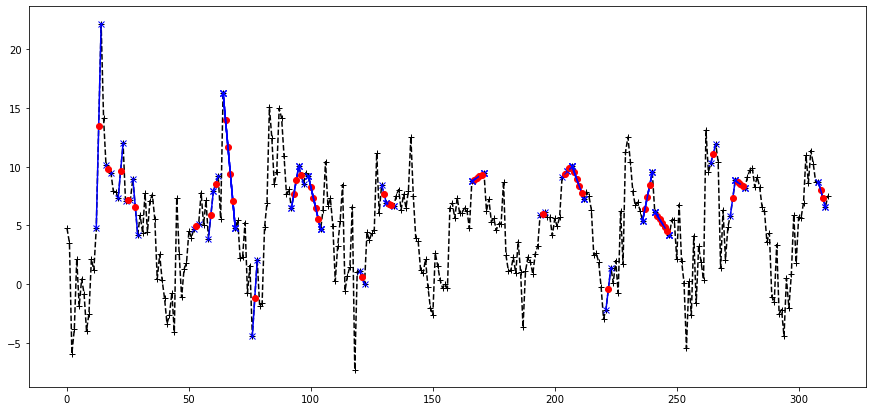

Gap-filling data column:  Basin_3_MERIS_Chl_a


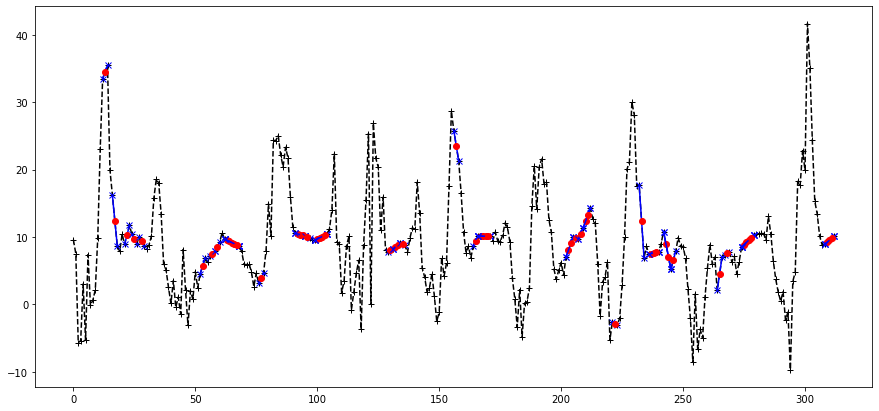

Gap-filling data column:  Basin_2_MERIS_Chl_a


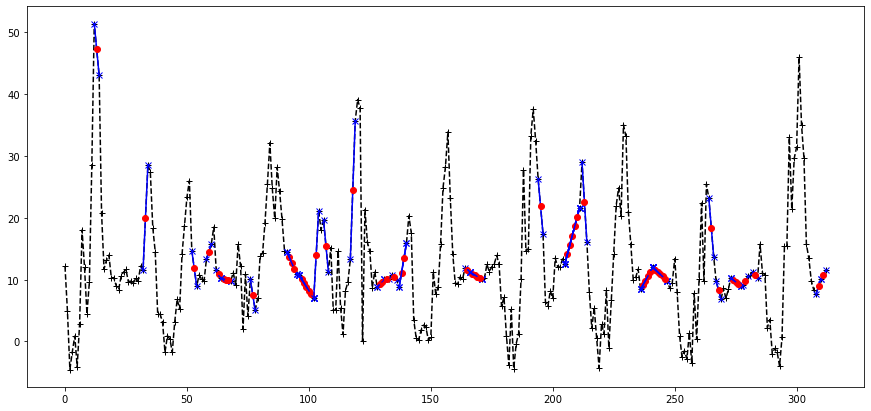

Gap-filling data column:  Basin_1_MERIS_Chl_a


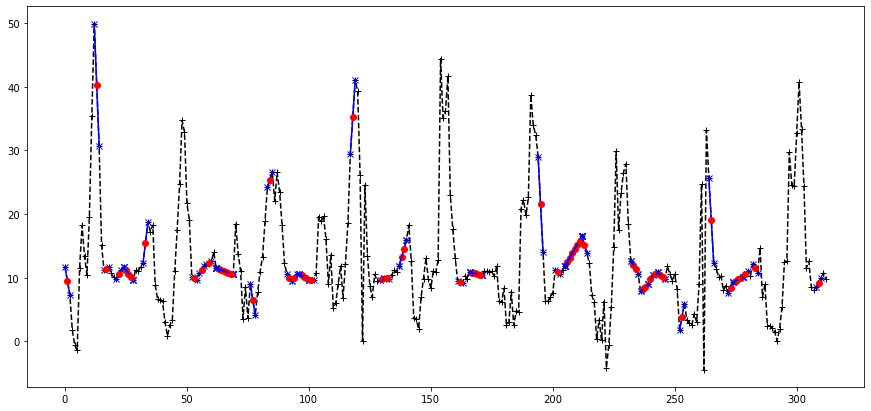

In [6]:
import statsmodels.formula.api as sm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('figure', figsize=(15, 7)) # change the default figure size

x = 'Date' # time step variable column name

chla_filled = chla.copy() # make an indentical copy of the dataframe
colnames = list(chla_filled) # get list of column names
print("Number of NaNs in each column:")
print(chla_filled.isnull().sum(axis = 0)) # get sum of all NaN values in each column
for c in colnames[1:len(colnames)]: # iterate over all columns in the dataframe, but omit index 0, which is the Date column
    print("Gap-filling data column: ", c)
    gaps = chla[c].index[chla[c].isna()] # gives a list of all the data gaps (NaN or None) as indices of the dataframe
    good = chla[c].index[chla[c].notnull()] # gives a list of all the good data points (not NaN or None) as indices of the dataframe
    plt.plot(chla[x].index[good], chla[c].iloc[good], '+k--') # the letter k indicates black line colour 
    #plt.xticks(chla[x].index, chla[x])
    #plt.show()
    #print(chla[c].iloc[gaps[0]])
    for t in gaps: # iterate over each gap
        tlow = max(chla[c].iloc[0:t].index[chla[c].iloc[0:t].notnull()]) 
            # time index of nearest earlier data point that is not NaN
        thi = min(chla[c].iloc[(t+1):nrow].index[chla[c].iloc[(t+1):nrow].notnull()]) 
            # time index of nearest later data point that is not NaN
        # you can uncomment the following line to see detailed output of the search algorithm:
        # print("Index: ", t, ".  Nearest good data pair: ", tlow, " and ", thi)
        ylow = chla[c].iloc[tlow] # value of nearest earlier data point
        yhi = chla[c].iloc[thi] # value of nearest later data point
        df = pd.DataFrame({"X": [tlow, thi], "Y": [ylow, yhi]}) # define a Pandas Dataframe
        model = sm.ols(formula="Y ~ X", data=df).fit() # fit a linear regression to the two data points
        yhat = model.predict(exog=dict(X=t)) # predict missing values for the gap at time t. We need to hand over the x values as a Python dictionary like so.
        chla_filled.at[t,c] = yhat # fill in the interpolated values into the gaps
        plt.plot(df["X"], df["Y"], 'xb-') # add the data points used for interpolation to the plot in blue
        plt.plot(t, yhat, 'or') # add interpolated data to the plot in red
    plt.show()

# Trend analysis

We will use an ordinary least-squares linear regression to check for a linear trend. There are at least 8 different packages offering this functionality in Python. Here, we use STATSMODELS, which offers the best output functionality.
The code below is written for time series data that have equal time intervals between data points and uses the time index as x values rather than the Date column.
Let's use Basin 1 as an example.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2.047
Date:                Fri, 03 Jan 2020   Prob (F-statistic):              0.154
Time:                        10:43:23   Log-Likelihood:                -1121.7
No. Observations:                 313   AIC:                             2247.
Df Residuals:                     311   BIC:                             2255.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.1351      0.986     14.342      0.0

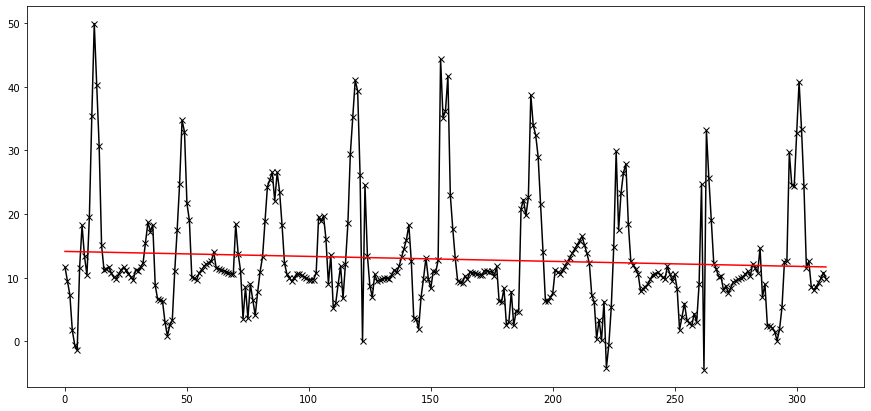

In [7]:
import statsmodels.api as sm

# define the dataframe columns for the trend analysis
xcol = 'Date' # independent variable
ycol = 'Basin_1_MERIS_Chl_a'# dependent variable

# pull out x and y data series
x = chla_filled[xcol].index.values
x = sm.add_constant(x) # this adds a column to x and makes the model include a constant (or intercept)
y = chla_filled[ycol].values

# fit the model
model = sm.OLS(y, x).fit()
print(model.summary())

# predict y from the data
chla_filled['B1pred'] = model.predict()

# plot the results
plt.plot(x[:,1], chla_filled[ycol], 'xk-') # plot the time series data
plt.plot(x[:,1], chla_filled['B1pred'], 'r-') # plot the linear model
plt.show()

The p value shows that at the 95% confidence level the slope is not statistically significant (p=0.154).

# Your portfolio task

For your practical portfolio, redo the analysis for a basin (1-4) of your choice. Add relevant graphs and figures and describe what you can infer from the trend analysis about the algal blooms in Lake Balaton.


# Seasonality analysis

We can decompose the time series into a trend, seasonal component and a residual error term. STATSMODEL offers a naive decomposition:
The additive model is Y[t] = T[t] + S[t] + e[t]
The multiplicative model is Y[t] = T[t] * S[t] * e[t]

The seasonal component is first removed by applying a convolution filter to the data. The average of this smoothed series for each period is the returned seasonal component.

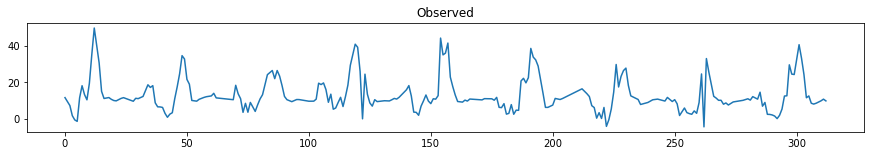

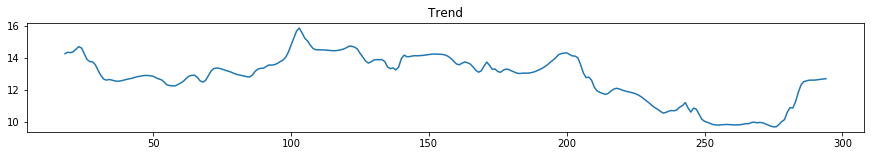

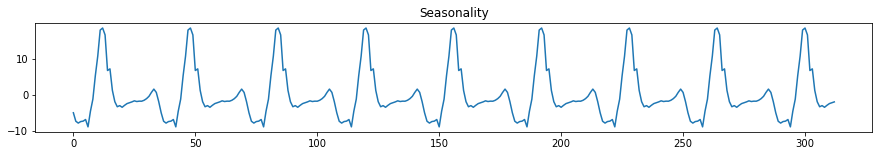

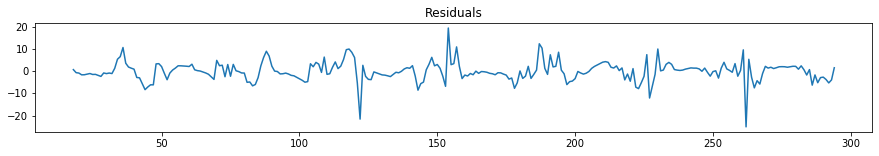

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

# define a frequency that we think causes the seasonality, here 36 dekads (10-day periods) per year
f = 36

# fit the model
result = seasonal_decompose(y, model='additive', freq=f)
plt.figure(figsize=(15,2))
plt.plot(result.observed)
plt.title("Observed")
plt.show()
plt.figure(figsize=(15,2))
plt.plot(result.trend)
plt.title("Trend")
plt.show()
plt.figure(figsize=(15,2))
plt.plot(result.seasonal)
plt.title("Seasonality")
plt.show()
plt.figure(figsize=(15,2))
plt.plot(result.resid)
plt.title("Residuals")
plt.show()

# Your portfolio task

Add relevant graphs and reflect on the decompositon of the time series of phytoplankton concentration in Lake Balaton into a trend, a seasonal component and a residual term. What does this analysis allow you to infer about the data?


# Autocorrelation analysis

This analysis tests whether the values in the time series are correlated with their predecessors.
The autocorrelation function calculates the correlation coefficient of the time series with itself shifted by lag x.
The partial autocorrelation function does the same, but eliminates the correlations with all lower lags.

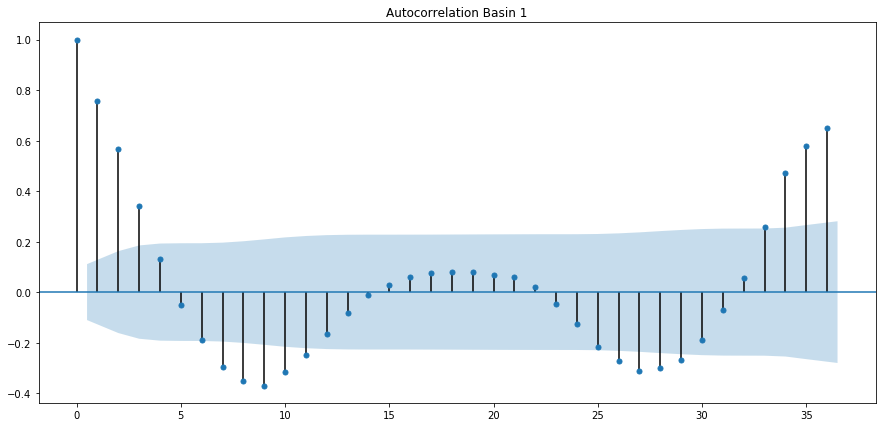

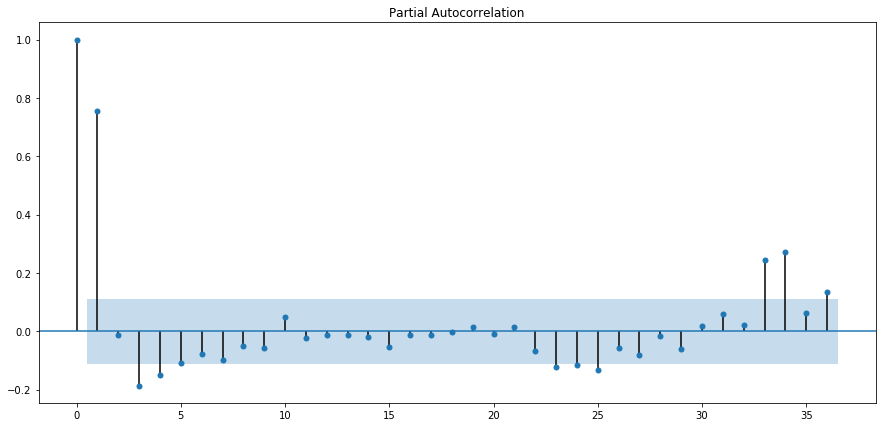

In [10]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# calculate the autocorrelation function, in case you want to use the results for further analysis
acfresult =  acf(y, unbiased=True, nlags=36, qstat=True, alpha=0.05, fft=True)

# plot the autocorrelation function graphically
plot_acf(y, unbiased=True, lags=36, alpha=0.05, title='Autocorrelation Basin 1')

# plot the partial autocorrelation function, which removes the correlation of all lower lags for each lag term
plot_pacf(y, lags=36)
plt.show()

# Your portfolio task

Change the 'lags' parameter and find the best value. Add relevant graphs and discuss the autocorrelation properties in the time series of phytoplankton concentration in Lake Balaton. Which environmental processes could influence the autocorrelation?


# ARIMA

Remember, ARIMA model has 3 parameters:
    p — Number of autoregressive terms of the model
    d — Number of nonseasonal differencing terms of the model
    q — Number of moving average terms of the model

Be aware that ARIMA requires stationary time series data. This means, we have to remove any trend over time and any seasonality if we want to apply this technique to this dataset. There is a better suited method for non-stationary seasonal data:

# Seasonal Autoregressive Integrated Moving-Average (SARIMA)

For our data, the Seasonal Autoregressive Integrated Moving Average (SARIMA) method is appropriate. It combines the ARIMA model with the ability to perform the same autoregression, differencing, and moving average modelling at the seasonal level.

The notation for the model involves specifying the order for the AR(p), I(d), and MA(q) models as parameters to an ARIMA function and AR(P), I(D), MA(Q) and m parameters at the seasonal level, e.g. SARIMA(p, d, q)(P, D, Q)m where “m” is the number of time steps in each season (the seasonal period). A SARIMA model can be used to develop AR, MA, ARMA and ARIMA models.

The method is suitable for univariate time series with trend and/or seasonal components.
The autocorrelation function gives important clues for the parameterisation of the ARIMA or SARIMA model.

Details of other methods: https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/

Here are some useful rules how to choose good parameters for ARIMA models: http://people.duke.edu/~rnau/arimrule.htm
And here for choosing SARIMA model parameters: https://www.datasciencecentral.com/profiles/blogs/tutorial-forecasting-with-seasonal-arima

The autocorrelation plot above shows us that the data have a positive autocorrelation for lag 1 that gradually declines for lags 2 to 4. This is a clue that our data has an AR term.
The partial autocorrelation plot shows positive partial autocorrelation for lags 1 and 2. This suggests that 2 AR terms are a good starting point for our model.
We can explore an expanded model that also includes an MA term.

In [11]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from random import random, sample
import time

In [12]:
# measure execution time of this model fitting
start = time.time()

# define the SARIMA parameters of model 1
p = 2 # 2 AR terms, based on partial autocorrelation function being positive for lags 1 and 2
d = 1 # to remove any longer-term trend by differencing
q = 0 # no MA term
ps = 2 # 2 seasonality AR terms based on partial autocorrelation function
ds = 1
qs = 0
ms = 36 # 36 dekads (10-day periods) are the length of one 'season' (year)

# fit model 1 
model1 = SARIMAX(y, order=(p,d,q), seasonal_order=(ps,ds,qs,ms))
SARIMA1result = model1.fit(disp=0)

# print the model result
print(SARIMA1result.summary())

# print execution time
end = time.time()
print("Execution time for model 1 (s) = % 10.4f" % (end - start))


                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  313
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 36)   Log Likelihood                -891.136
Date:                            Fri, 03 Jan 2020   AIC                           1792.271
Time:                                    10:45:18   BIC                           1810.373
Sample:                                         0   HQIC                          1799.536
                                            - 313                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4046      0.035    -11.658      0.000      -0.473      -0.337
ar.L2         -0.2311      0.054   

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  313
Model:             SARIMAX(2, 1, 1)x(2, 1, 0, 36)   Log Likelihood                -870.125
Date:                            Fri, 03 Jan 2020   AIC                           1752.249
Time:                                    10:46:20   BIC                           1773.972
Sample:                                         0   HQIC                          1760.966
                                            - 313                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4054      0.042      9.745      0.000       0.324       0.487
ar.L2          0.0616      0.059   

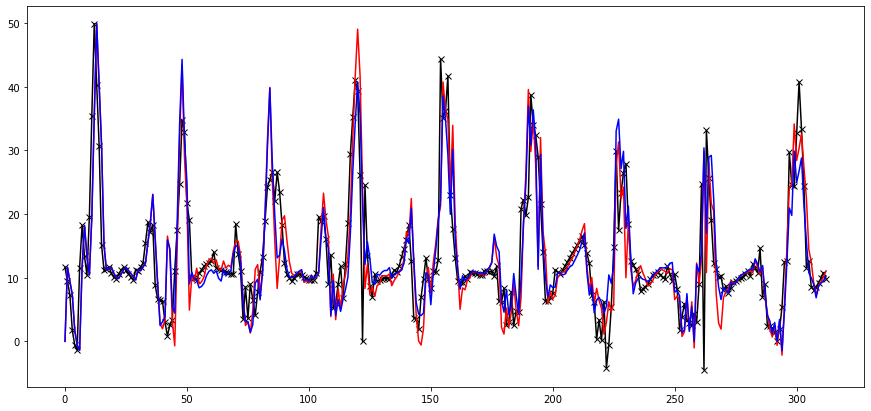

In [13]:
# this bit can take some time to compute (5-15 minutes when I tried it out)
# measure execution time of this model fitting
start = time.time()

# define the SARIMA parameters of model 2
p = 2 # 2 AR terms, based on partial autocorrelation function being positive for lags 1 and 2
d = 1 # to remove any longer-term trend by differencing
q = 1 # add an MA term
ps = 2 # 2 seasonality AR terms based on partial autocorrelation function
ds = 1 # seasonal differencing
qs = 0 # no seasonal MA term
ms = 36 # 36 dekads (10-day periods) are the length of one 'season' (year)

# fit model 2 
model2 = SARIMAX(y, order=(p,d,q), seasonal_order=(ps,ds,qs,ms))
SARIMA2result = model2.fit(disp=0)

# print the model result
print(SARIMA2result.summary())

# print execution time
end = time.time()
print("Execution time for model 2 (s) = % 10.4f" % (end - start))

# measure execution time of the model predictions
start = time.time()

# In-sample one-step-ahead predictions
# One-step-ahead prediction uses the true values of the endogenous values at each step to predict the next in-sample value. 
yhat1 = SARIMA1result.predict(start=0, end=len(y)-1)
yhat2 = SARIMA2result.predict(start=0, end=len(y)-1)

# print execution time
end = time.time()
print("Execution time for model predictions (s) = % 10.4f" % (end - start))

# plot the results
plt.plot(x[:,1], y, 'xk-') # plot the time series data
plt.plot(x[:,1], yhat1, 'r-') # plot the linear model
plt.plot(x[:,1], yhat2, 'b-') # plot the linear model
plt.show()


If you have done this with the Basin 1 data, then we can see from the results above that both models (with and without the MA term) provide a good fit to the data. Based on the summary tables of the model results, model 1 is a better fit. This is evident from three things: (i) the Akaike Information Criterion (AIC) is higher; (ii) model 2 fails to converge to a solution (see warning message), (iii) all MA terms are not statistically significant (P-values >0.05).
If you have used a different Basin, interpret your results.

# Your portfolio task

Change some of the SARIMA parameters and find a model that you think is good. 
Add relevant graphs and tables to your portfolio and discuss why you chose that particular model.


# Harmonic analysis

Harmonic analysis (sometimes called HANTS) is based on a Fourier transform of the time-series.

Here is an implementation of HANTS for Python 2.7 that allows direct analysis of stacks of images: https://github.com/gespinoza/hants

If we write code in a Python environment, we can call an executable R script from within Python: 
To create an R executable file, we just need to add this in the first line of the R script:
    #! /usr/bin/Rscript
and give it execution rights under file permissions.
Then we can call the R script from Python with subprocess:
    subprocess.call ("/pathto/MyrScript.r")
https://www.linkedin.com/pulse/interfacing-r-from-python-3-jupyter-notebook-jared-stufft/

What we are going to do in this Notebook is running R code directly in a Jupyter Notebook cell.
In our environment, we have installed some packages to make this work: rpy2 and tzlocal.
rpy2 needs to be of a specific version, to be compatible with the Windows Operating System.

In [14]:
import rpy2.rinterface
%load_ext rpy2.ipython

# define working directory to be handed to R script
# this must point to the location of the data file "Balaton_Chla_HB-harmonics.txt"
wd = r'z:\gy7709\practicals'

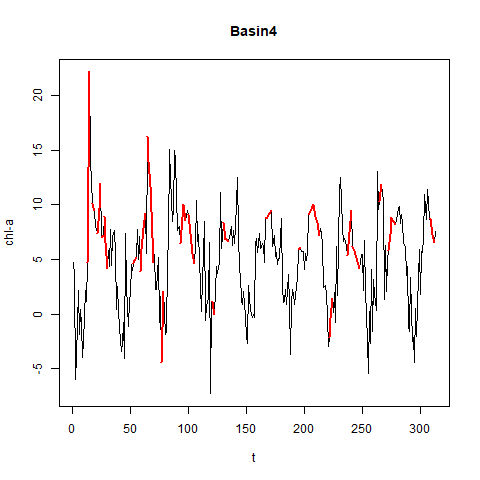

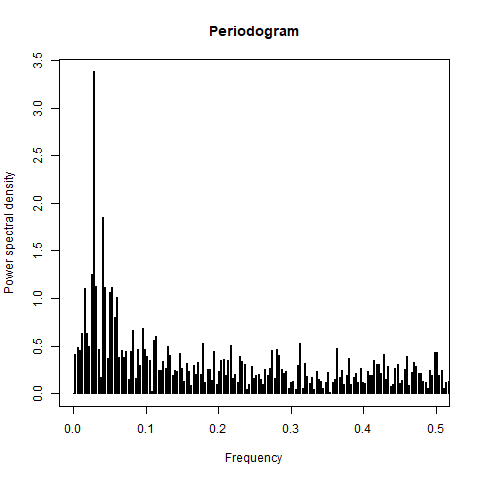

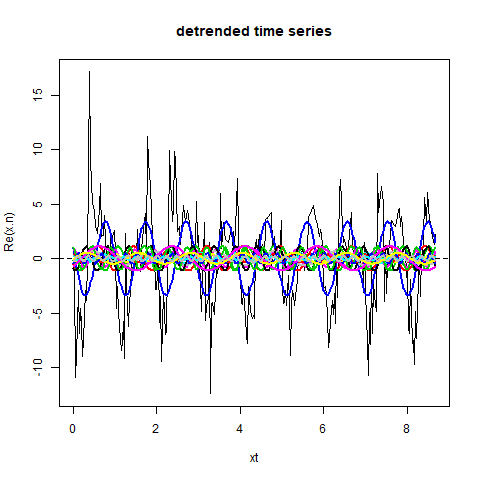

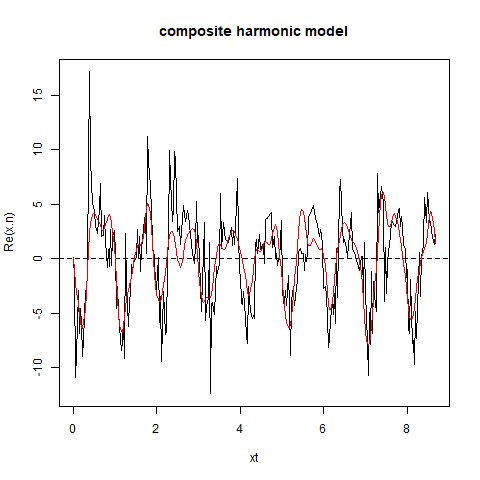

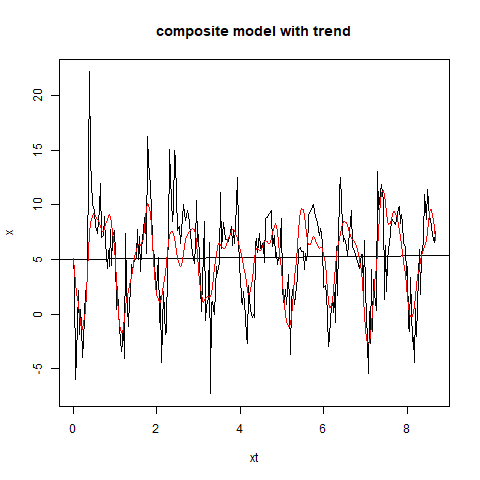

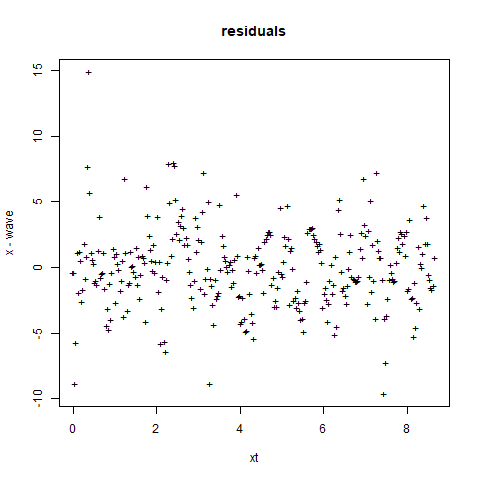

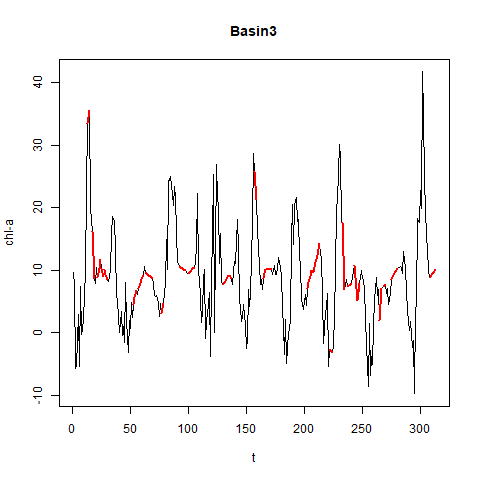

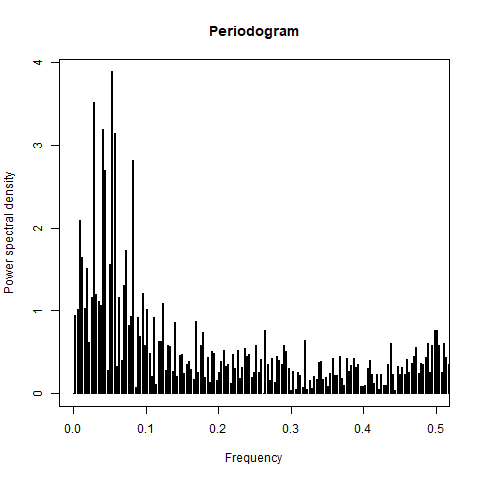

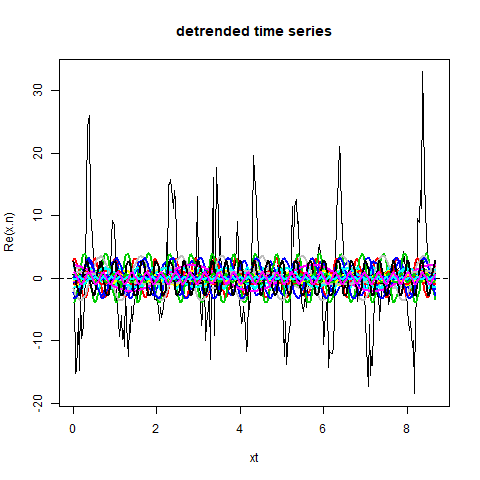

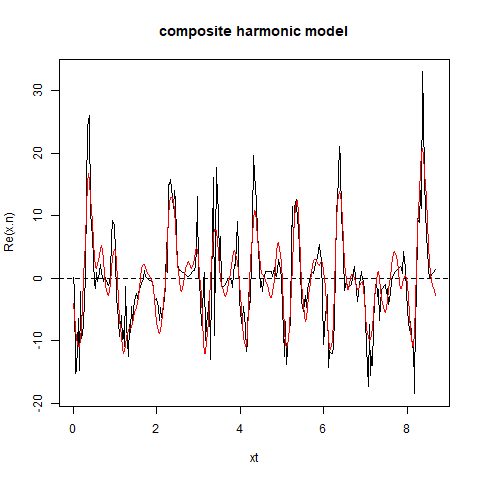

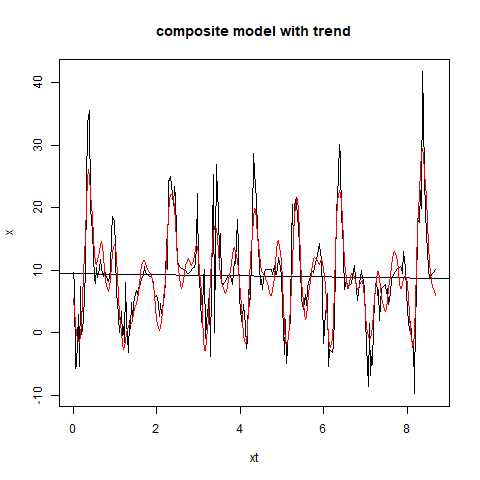

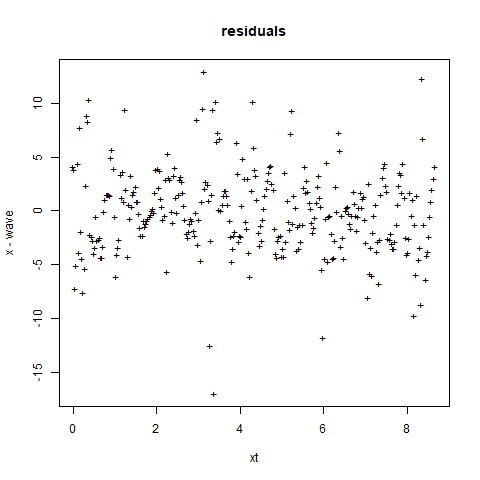

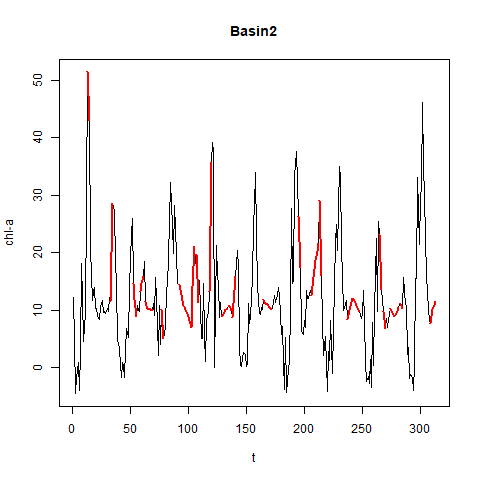

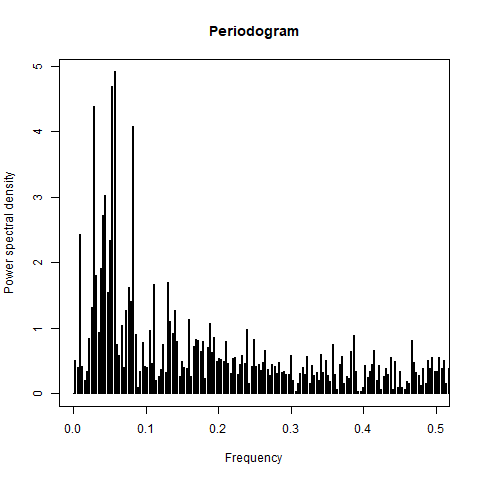

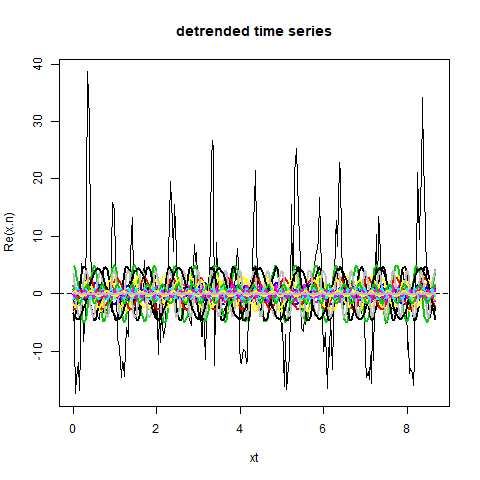

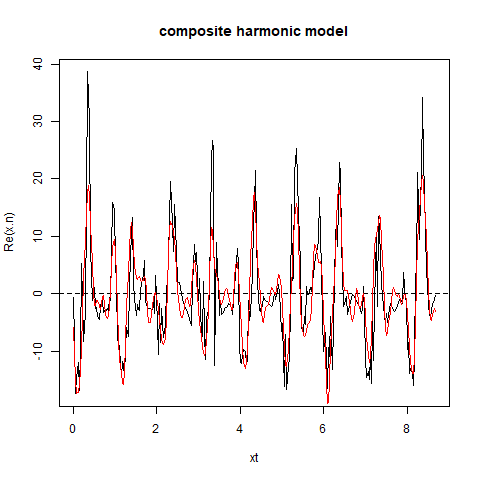

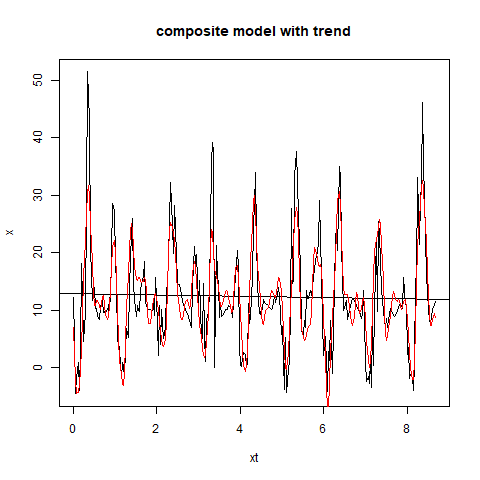

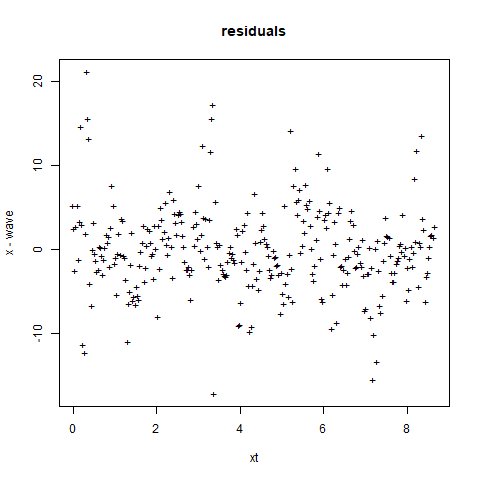

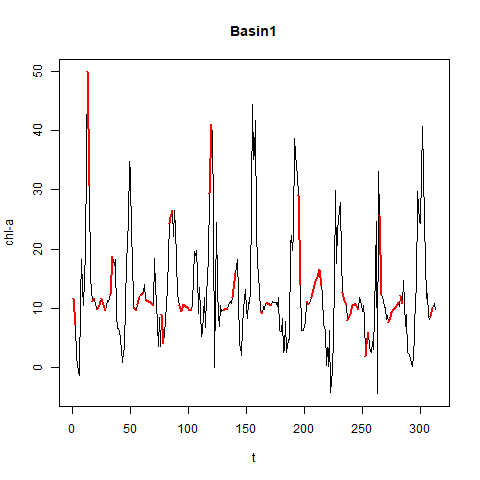

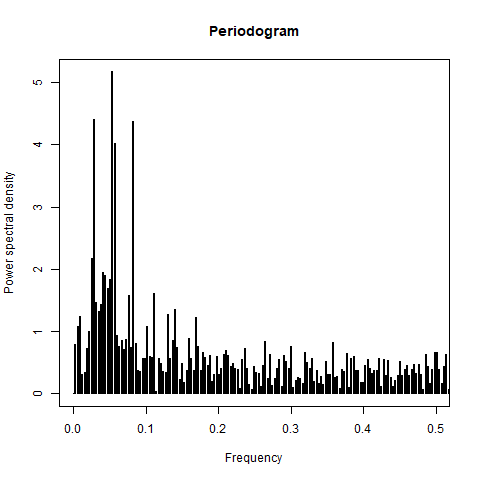

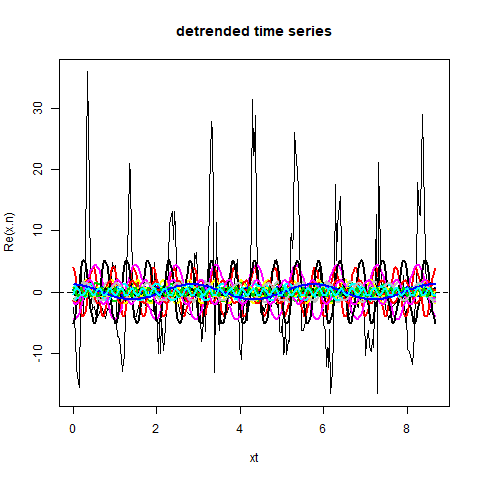

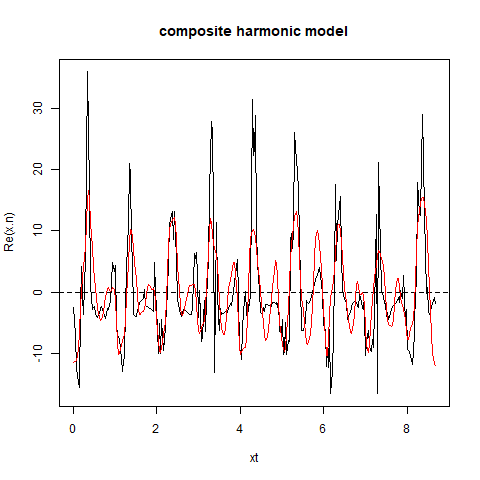

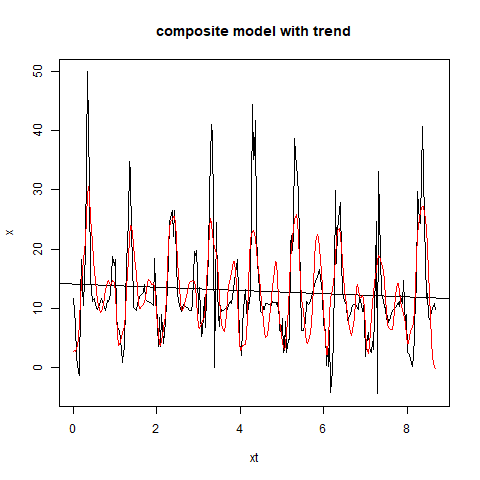

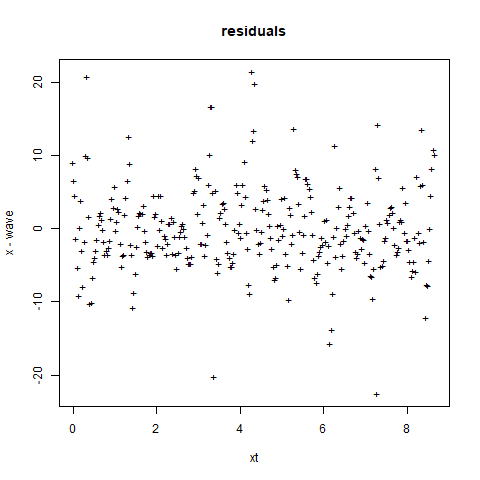

In [15]:
%%R -i wd
# switch from Python to R programming language for this Notebook cell
# and hand over a variable with the working directory

#######################################
# Code for harmonic analysis in R
#######################################
#
# written by Heiko Balzter, copyright University of Leicester (2014)
# includes modified functions from source: http://www.di.fc.ul.pt/~jpn/r/fourier/fourier.html
#
#######################################

# t is a time index from 0 to n-1 where n is the number of measurements in the time-series
# xt is the vector of time points at which the measurements were taken
# The amplitude of a wave is defined as half the height from the maximum to the minimum point.
# The phase of the wave is defined as the angle by which the sine wave is delayed to its first peak.
# A harmonic term is defined by how many complete waves it has within the defined time series, from start to end,
#    i.e. harmonic term 2 has two full waves (two maxima and two minima) within the time series.
# The fundamental period is the period between the first sample and the last.
# The acquisition frequency is the number of measurements between two successive units of time. 
# The fundamental frequency f_0 is 1/N where N is the number of time steps. 
# The frequencies of the wave components must be integer multiples of the fundamental frequency.
# f_0 is called the first harmonic, the second harmonic is 2*f_0, the third is 3*f_0, etc.

get.trajectory <- function(X.k,xt,acq.freq) {
# Inverse Fourier Transform: 
# Returns the x.n time series for a given time sequence (xt) and a vector with the amount of frequencies k in the signal (X.k)
  n   <- length(xt)
  i   <- complex(real = 0, imaginary = 1)
  x.n <- rep(0,n)
  ks  <- 0:(length(X.k)-1)
  for(j in 0:(n-1)) { # compute each time point x_n based on freqs X.k
    x.n[j+1] <- sum(X.k * exp(i*2*pi*ks*j/n)) / n
  }
  x.n * n
}

plot.fourier <- function(fourier.series, f.0, xt, ...) {
# plot a Fourier series
# ***** This function has been verified. *****
  w <- 2*pi*f.0
  trajectory <- sapply(xt, function(t) fourier.series(t,w))
  plot(xt/length(xt), trajectory, type="l", xlab="time", ylab="f(t)"); abline(h=0,lty=3)
}

convert.fft <- function(x.k, acq.freq=1) {
# convert a FFT to amplitude and phase
# x.k is the vector of complex points to convert
  n <- length(Re(x.k)) # number of points
  x.k <- x.k / n # normalize
  distance.center <- function(c)signif( Mod(c),        4)
  angle           <- function(c)signif( 180*Arg(c)/pi, 3)
  df <- data.frame(cycle    = 0:(n-1),
                   freq     = 0:(n-1) / acq.freq,
                   t        = n / 0:(n-1) / acq.freq, # in time units, not sequential units
                   ampl     = sapply(x.k, distance.center) * 2 * n,
                   phase    = sapply(x.k, angle))
  df
}

plot.frequency.spectrum <- function(X.k, acq.freq=acq.freq, col = 1, lwd = 2, pch = "+", ...) {
# plot a frequency spectrum of a given X_k
  xax <- (0:(length(X.k)-1)) / length(X.k) * acq.freq
  xlimits <- c(0, max(xax)/2)
  plot.data  <- cbind( xax, 2 * Mod(X.k))
  plot(plot.data, t="h", main="Periodogram", xlab="Frequency", ylab="Power spectral density",
       col = col, lwd = lwd, pch = pch, xlim=xlimits, ylim=c(0,max(Mod(plot.data[,2]))))
}

plot.harmonic <- function(xk, i, xt, acq.freq, mar=c(1,1,1,1),
  col = 3, lwd = 2, pch = "+", cex.lab = 1, cex.axis = 1, cex.main = 1, cex.sub = 1, ...) {
# plot.harmonic() plots the i-th harmonic on the current plot
# xk: the frequencies computed by the FFt
#  i: which harmonic
# xt: the sampling time points
# acq.freq: the acquisition rate
  xk.h <- rep(0,length(xk))
  xk.h[i+1] <- xk[i+1] # i-th harmonic
  harmonic.trajectory <- 2 * get.trajectory(xk.h, xt, acq.freq=acq.freq)
  points(xt, Re(harmonic.trajectory), type="l", mar=mar,
       col = col, lwd = lwd, pch = pch, cex.lab = cex.lab, cex.axis = cex.axis,
       cex.main = cex.main, cex.sub = cex.sub)
}

get.harmonic <- function(xk, i, xt, acq.freq) {
# Get the values that define the i-th harmonic term.
# xk: the frequencies computed by the FFt
#  i: which harmonic term(s)
# xt: the sampling time points
# acq.freq: the acquisition rate
  xk.h <- rep(0,length(xk))
  xk.h[i+1] <- xk[i+1] # i-th harmonic
  harmonic.trajectory <- 2 * get.trajectory(xk.h, xt, acq.freq=acq.freq)
  Re(harmonic.trajectory)
}

harmonic <- function(xt, x, acq.freq, N, alpha, detrend, which, test, ...) {
# core harmonic analysis function
# xt = a vector of time steps in units of s,min, hr or other time units, does not have to be integers
# x = a vector of time-series observations with the same length as xt
# N = number of the harmonic terms to be included, starting with largest amplitude
# acq.freq = number of measurements between two successive units of time. 
# alpha = type I error probability for statistical significance testing (default 0.05 or 5%)
# detrend = TRUE or FALSE, if TRUE (default) then linear detrending is applied to the data
# which = "strongest": the N strongest harmonic terms are included in the model (default)
#       = "first": the first N terms are included, or
#       = "all": all harmonics are included.
# test = "bonferroni" adjusts type I error by the number of tests N; "holm" adjusts the type I error by N+1-k where k=1:N 
#
# How to understand the harmonic terms: 
# Cycle means the number of waves in the time series, i.e. cycle = 9 the wave fits 9 times into the length of the data
#      which is the annual cycle for a 9-year series. 
# Freq is the position in the frequency domain (periodogram) from 0 to 0.5. 
# t is the position in the time domain from 0 to n-1 where n is the number of measurements. 
# Amplitude is the strength of the wave and 
# phase is the delay of the wave in degrees (0-360).

  dig.aov <- 4 # number of significant digits for ANOVA table
  if (missing(acq.freq)) acq.freq <- 1
  if (missing(N)) N <- 20
  if (missing(alpha)) alpha <- 0.05
  if (missing(detrend)) detrend <- TRUE
  if (missing(which)) which <- "strongest"
  if (!(which %in% c("strongest", "first", "all"))) which <- "strongest"
  if (missing(test)) test <- "bonferroni"
  if (!(test %in% c("bonferroni", "holm"))) test <- "bonferroni"
  t <- 0:(n-1)
  # detrending
  n <- length(x)
  if (detrend) {
    trend <- lm(x~xt) # linear model
    cat("Linear detrending result:\n")
    print(summary(trend))
    detrended.x <- trend$residuals
    } else {
    cat("No detrending.\n\n")
    detrended.x <- x
    trend <- "No detrending"
    }

  detrended.x.k <- fft(detrended.x) / n
  plot.frequency.spectrum(detrended.x.k, acq.freq=acq.freq, main="frequency spectrum")

  # Calculate the amplitude and phase angle for the N harmonic terms
  # Cycle 9 means that the harmonic wave repeats 9 times over the time series
  # Note that cycle is indexed from 0 and ndx from 1
  x.fft <- convert.fft(detrended.x.k, acq.freq)
  nx <- length(x.fft$cycle)
  # you can get the components of the table from:
  #   x.fft$cycle[ndx]
  #   x.fft$freq[ndx]
  #   x.fft$t[ndx]
  #   x.fft$ampl[ndx]
  #   x.fft$phase[ndx]

  # find the N strongest harmonics
  if (which=="strongest") {
    ndx <- order(x.fft$ampl[1:(nx/2)], decreasing = T)[1:N]
    cat(paste(N, "strongest harmonic terms:\n", sep=" "))
    write.table(round(x.fft[ndx,],4), quote = F, sep = "\t", row.names=F)
    cat("\n")
    }
  if (which=="first") {
    ndx <- 2:(N+1)
    cat(paste(N, "first harmonic terms:\n", sep=" "))
    write.table(round(x.fft[ndx,],4), quote = F, sep = "\t", row.names=F)
    cat("\n")
    }
  if (which=="all") {
    ndx <- 1:n
    cat(paste("All harmonic terms:\n", sep=" "))
    write.table(round(x.fft[ndx,],4), quote = F, sep = "\t", row.names=F)
    cat("\n")
    }

  # test for significance of the individual harmonic terms using the F test
  # Reference: Hartley, H. O. (1949): Tests of Significance in Harmonic Analysis. Biometrika, 36, 194-201.
  # time dimension ts is in arbitrary units, with acq.freq measurements between two successive units 1 and 2, say
  # without loss of generality, for the purpose of the significance testing we treat the 
  #     time dimension as steps of 1, 2, ..., n
  # we do this by adjusting the time index tn <- xt * acq.freq

  if (which=="strongest" || which=="first") {
  bonferroni <- alpha / N   # adjusted alpha probability by the number of comparisons, Bonferroni correction
  holm <- alpha / seq(N, 1, -1)   # adjusted alpha probability, Bonferroni/Holm correction
  gamma = 2*pi/n # in Hartley's paper, but only for time steps of 1
  a0 <- mean(detrended.x)
  # work out the mean squares (MSQ) of each harmonic term for ANOVA table
  ssq <- rep(0, N) # SSQ components 
  df <- rep(2, N) # degrees of freedom
  msq <- rep(0, N) # MSQ components = SSQ / df
  a <- rep(0, N) # ai
  b <- rep(0, N) # bi
  f <- rep(0, N) # F values for each harmonic term
  p <- rep(0, N) # p values for each harmonic term
  sig <- rep("n.s.", N) # significance
  for (i in 1:N) {
    a[i] <- 2/n * sum(detrended.x * cos(x.fft$cycle[ndx[i]] * t * gamma)) # note that we use t here and not xt, see above
    b[i] <- 2/n * sum(detrended.x * sin(x.fft$cycle[ndx[i]] * t * gamma))
  }
  # calculate SSQ terms
  ssq <- n/2*(a^2+b^2)
  # calculate MSQ terms
  msq <- ssq/df
  # Calculate the residual MSQ variance component:
  rssq <- sum((detrended.x-a0)^2) - n/2 * sum(a^2+b^2)
  # The total df is n-1. The residual df is the total n  2N - 1.
  rdf <- n-2*N-1 # residual df
  rmsq <- rssq/rdf
  # Work out the F values:
  f <- msq / rmsq
  # Each harmonic term has 2 degrees of freedom since it is characterised by 2 parameters ai and bi. 
  # The F ratio is calculated by dividing the MSQ of each harmonic term by the residual MSQ. It should be compared to the F distribution for 2,11 degrees of freedom for the 5%/m point, assuming type I error is controlled at 5%.
  p <- pf(f, df1=2, df2=n-N*2-1, lower=FALSE)
  # rounding for pretty printing:
  ssq <- round(ssq, 2)
  msq <- round(msq, 2)
  f <- round(f, 1)
  p <- round(p, 5)
  bonferroni <- round(bonferroni, 5)
  holm <- round(holm, dig.aov)
  rssq <- round(rssq, dig.aov)
  rmsq <- round(rmsq, dig.aov)
  # now merge all into a data.frame
  if (test=="bonferroni") {
    sig[p<bonferroni] <- "*"
    x.aov <- as.data.frame(cbind(x.fft$cycle[ndx], ssq, df, msq, f, p, bonferroni, sig))
    names(x.aov) <- c("cycle", "SSQ", "df", "MSQ", "F", "p", "pBonf", "Sig")
    }
  if (test=="holm") {
    sig[p<holm] <- "*"
    for (i in 1:(N-1)) if (p[i]>=holm[i]) sig[(i+1):N] <- rep("n.s.", N-i)
    x.aov <- as.data.frame(cbind(x.fft$cycle[ndx], ssq, df, msq, f, p, holm, sig))
    names(x.aov) <- c("cycle", "SSQ", "df", "MSQ", "F", "p", "pHolm", "Sig")
    }
  # print it
  cat("ANOVA table for the selected harmonic terms:\n")
  write.table(format(x.aov, trim = FALSE, justify = "right"), quote = F, sep = "\t", row.names=F)
  write.table(format(cbind("Res.", rssq, rdf, rmsq), trim = FALSE, justify = "right"), quote = F, sep = "\t", row.names=F, col.names=F)
  cat("\n")
  x.aov <- merge.data.frame(x.aov, data.frame(c(NA, round(rssq,dig.aov), rdf, round(rmsq,dig.aov), NA,NA,NA,NA), row.names = names(x.aov)))

  if (which=="strongest") { # select only the significant harmonic terms
    ndxs <- ndx[sig=="*"]
    N <- length(ndxs)
    cat("\nRetaining ", N, "significant harmonic terms.\n")
    }
  if (which=="first") { # select the first N harmonic terms
    ndxs <- ndx
    cat("\nRetaining the first", N, " harmonic terms.\n")
    }

  # plot detrended time series and overlay the individual N significant harmonics with the largest amplitudes:
  # only plot up to 40 harmonics
  x.n <- get.trajectory(detrended.x.k, xt, acq.freq)  # create time wave from detrended data (if detrending is switched on)
  par(mfrow = c(1,1))
  plot(xt, Re(x.n), type="l", lwd=1, main="detrended time series")
  abline(h=0,lty=2)
  for (i in 1:min(40, N)) plot.harmonic(detrended.x.k, ndxs[i], xt, acq.freq, col=i+1)

  # Now plot detrended time series and the composite of the first significant N harmonics:
  plot(xt, Re(x.n), type="l", lwd=1, main="composite harmonic model")
  abline(h=0, lty=2)
  wave <- get.harmonic(detrended.x.k, ndxs, xt, acq.freq)
  lines(xt, wave, col="red")

  # And now plot add the trend back on to the composite of the first N harmonics:
  if (detrend) {
    plot(xt, x, type="l",lwd=1, main="composite model with trend")
    abline(trend)
    wave <- wave + trend$coef[1] + trend$coef[2] * xt
    lines(xt, wave, col="red")
    }

  # plot residuals
    plot(xt, x - wave, type="p", pch="+", main="residuals")
  }
  else
  { # if which == "all"
  ndxs <- 2:n # in case all harmonics will be included except term 0
  N <- n
  x.aov <- "No ANOVA available. All harmonics are included."
  wave <- x
  }

  # return these components:
  harm <- list(xt)
  names(harm) <- "xt"
  harm$lm <- trend
  harm$detrended <- detrended.x
  harm$Nsig <- N
  harm$ndx <- ndx
  harm$frequency.spectrum <- detrended.x.k
  harm$Amp <- x.fft$ampl[ndx]
  harm$Ph <- x.fft$phase[ndx]
  harm$aov <- x.aov
  harm$fitted.values <- wave
  harm$residuals <- x - wave
  harm$call <- match.call()
  class(harm) <- "harmonic"

  # return results  
  harm
}
##################
# end of functions
##################

###############
# MAIN code
###############

# set working directory
setwd(wd)

# set the handling of warning messages. 
# If warn is negative all warnings are ignored. 
# If warn is zero (the default) warnings are stored until the toplevel function returns. 
#     If 10 or fewer warnings were signalled they will be printed otherwise a message saying how many were signalled. An object called last.warning is created and can be printed through the function warnings. If warn is one, warnings are printed as they occur. 
# If warn is two or larger all warnings are turned into errors.
options(warn=0)

####################################
# Process Chlorophyll-a data from Lake Balaton by Palmer et al. (2014):
####################################

file <- "Log_Balaton_Chla_harmonics.txt"
sink(file)
cat("Balaton chlorophyll-a analysis from MERIS\n")
cat("Log file: ", file, "\n")
file <- "Balaton_Chla_HB-harmonics.txt"
cat("Data file: ", file, "\n")
chla <- read.table(file, sep="\t", header=TRUE)
time <- length(chla[,1])/36              # measuring time interval (in years), the original data is in dekads
acq.freq <- 36                           # data acquisition frequency (Hz), how many measurements per year
ts <- seq(0,time-1/acq.freq, 1/acq.freq) # vector of sampling time-points in months
n <- length(chla[,1])
f.0 <- 1/time
chlafilled <- chla
for (site in 1:length(chla[1,])) {
  cat("\nSite: ", names(chla)[site], "\n")
  cat("\nGap-filling the data:\n")
  cat("Number of NAs: ", length(which(is.na(chla[, site]))), "\n")
  plot(chla[,site], type="l", xlab="t", ylab="chl-a", lwd=1, main=names(chla)[site]) 
  for (t in 1:length(chla[,1])) { # for each time step
    if (is.na(chla[t,site])) { # is the value missing?
      tlow <- max(which(!is.na(chla[1:(t-1), site]))) # time index of nearest earlier data point
      thi  <- t+min(which(!is.na(chla[(t+1):n, site]))) # time index of nearest later data point
      xlow <- chla[tlow, site] # value of nearest earlier data point
      xhi  <- chla[thi,  site] # value of nearest later data point
      tt <- c(tlow, thi)
      xx <- c(xlow, xhi)
      xlm <- lm(xx~tt)
      chlafilled[t,site] <- xlm$coef[1]+xlm$coef[2]*t # fill in
      lines(c(t-1, t), c(chlafilled[t-1,site],chlafilled[t,site]), type="l",col=2, lwd=2)
      if (!is.na(chlafilled[min(t+1,n),site])) lines(c(t, min(t+1,n)), c(chlafilled[t,site],chlafilled[min(t+1,n),site]), type="l",col=2, lwd=2)
      } # endif
    } # end of for t
  cat("\nCalculating harmonic terms for site .", names(chla)[site],"\n")
  chla.harm <- harmonic(ts, chlafilled[,site], N=40, alpha=0.05, detrend=TRUE, which="strongest", test="holm")
  if (site==1) b1.harm <- chla.harm # store the results
  if (site==2) b2.harm <- chla.harm # note that the site numbers are column numbers
  if (site==3) b3.harm <- chla.harm # they do not necessarily match the data column names
  if (site==4) b4.harm <- chla.harm
} # end for site

#############################
# Now, make publication quality graphs, equal axes etc.
# resolution of jpeg in dpi
res <- 72
# width
width <- 24*res
# height
height <- 14*res
# point size for text
ps <- 30
# colour of second data plots
col <- 2
#############################
for (site in 1:length(chla[1,])) {
  if (site==1) chla.harm <- b1.harm
  if (site==2) chla.harm <- b2.harm
  if (site==3) chla.harm <- b3.harm
  if (site==4) chla.harm <- b4.harm

  cat("Plotting the gap filled data.\n")
  jpeg(filename = paste(names(chla)[site], "_data.jpg", sep=""), width = width, height = height, 
      units = "px", pointsize = ps, quality = 100, bg = "white", res = res)
  plot(chla.harm$xt, chlafilled[,site], type="l", col=col, lwd=3, lty=2, main=names(chla)[site],
    ylim=c(0,50))
  lines(chla.harm$xt, chla[,site], type="l", xlab="t", ylab="chl-a", lwd=3, col=1)
  dev.off()

  cat("Plotting the periodogram.\n")
  jpeg(filename = paste(names(chla)[site], "_periodogram.jpg", sep=""), width = height, height = height, 
      units = "px", pointsize = ps, quality = 100, bg = "white", res = res)
  plot.frequency.spectrum(chla.harm$frequency.spectrum, acq.freq=acq.freq)
  dev.off()

  cat("Plotting the individual harmonic terms.\n")
  jpeg(filename = paste(names(chla)[site], "_harmonics.jpg", sep=""), width = width, height = height, 
      units = "px", pointsize = ps, quality = 100, bg = "white", res = res)
  plot(chla.harm$xt, chlafilled[,site]-chla.harm$lm[[1]][1]-chla.harm$lm[[1]][2]*chla.harm$xt, 
      type="l", lwd=2, ylim=c(-20,40))
  abline(h=0,lty=2)
  N <- chla.harm$Nsig
  for (i in 1:N) {
    plot.harmonic(chla.harm$frequency.spectrum, chla.harm$ndx[i], chla.harm$xt, acq.freq, col=i+1)
    }
  dev.off()

  cat("Plotting the composite harmonic model with trend added back on against the original data.\n")
  jpeg(filename = paste(names(chla)[site], "_predicted.jpg", sep=""), width = width, height = height, 
      units = "px", pointsize = ps, quality = 100, bg = "white", res = res)
  plot(chla.harm$xt, chlafilled[,site], type="l", col=1, lwd=2, ylim=c(0,50))
  lines(chla.harm$xt, Re(chla.harm$fitted.values), type="l", xlab="t", ylab="chl-a", lwd=2, col=col)
  abline(chla.harm$lm, lty = 2)
  dev.off()

  cat("Plotting the residuals.\n")
  jpeg(filename = paste(names(chla)[site], "_residuals.jpg", sep=""), width = width, height = height, 
      units = "px", pointsize = ps, quality = 100, bg = "white", res = res)
  plot(chla.harm$xt, chla.harm$residuals, col=1, lwd=2, pch="+", ylim=c(-20,20))
  dev.off()
}

sink()

cat("Read the log file: ", wd, "/", file)


# Don't forget:

The R code creates graphics files in the data directory and writes a log file. Check them out.
    

# Your portfolio task

Choose a basin and add the harmonic analysis results (graphs and/or tables) to your practical portfolio. Explain whether in your opinion, this analysis adds new information to the previous methods.

# Wavelet analysis

Now on to the wavelets.


The wavelet plot above has the frequency on the y axis, time on the x axis and the colours show the magnitude of the correlation of the time-series data with the wavelet we chose.


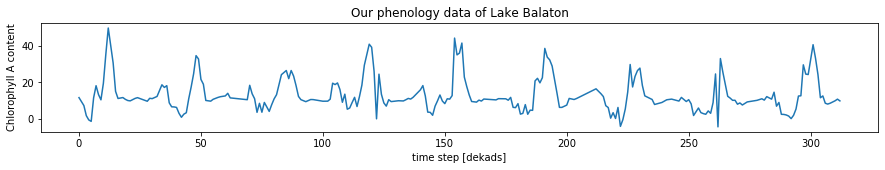

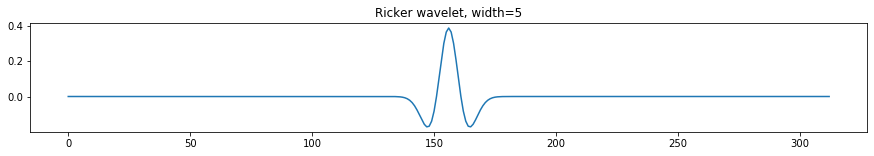

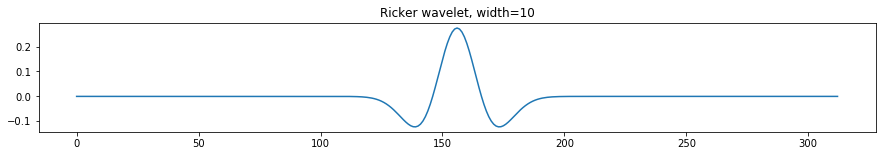

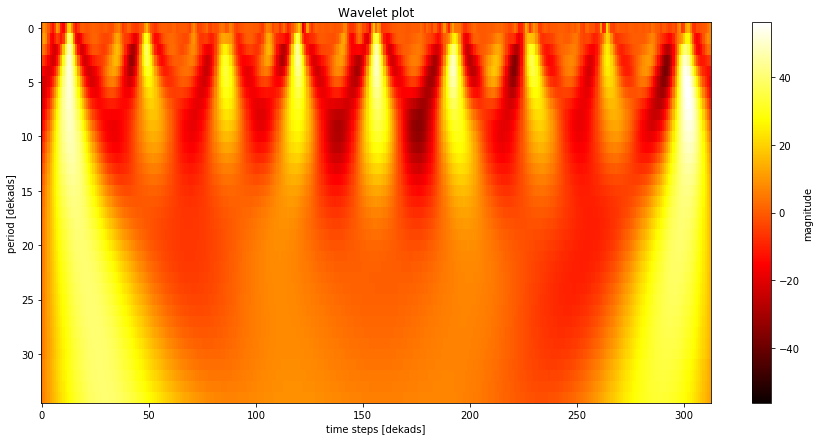

In [16]:
from scipy import signal

# remember that column 1 (the second column after column zero) of x and y (only has one column) 
#     contain our phenology data from Lake Balaton used earlier:
plt.figure(figsize=(15,2))
plt.plot(x[:,1],y)
plt.xlabel('time step [dekads]')
plt.ylabel('Chlorophyll A content')
plt.title('Our phenology data of Lake Balaton')
plt.show()

# print and plot the Ricker wavelet function
a = 5.0 # width parameter
vec5 = signal.ricker(len(x[:,1]), a)
a = 10.0 # now change the width of the wavelet
vec10 = signal.ricker(len(x[:,1]), a)
plt.figure(figsize=(15,2))
plt.plot(vec5)
plt.title("Ricker wavelet, width=5")
plt.show()
plt.figure(figsize=(15,2))
plt.plot(vec10)
plt.title("Ricker wavelet, width=10")
plt.show()

# now fit the wavelet function to the time series data
maxw = 36 # maximum width of the wavelet
widths = np.arange(1, maxw) # widths of the wavelet used for the wavelet transform
cwt_result = signal.cwt(y, signal.ricker, widths)
vmax=abs(cwt_result).max() # set colour range
vmin=-abs(cwt_result).max()
plt.imshow(cwt_result, cmap='hot', aspect='auto', vmax=vmax, vmin=vmin)
plt.xlabel('time steps [dekads]')
plt.ylabel('period [dekads]')
plt.title('Wavelet plot')
plt.colorbar(label='magnitude')
plt.clim(vmin,vmax)
plt.show()


Above, you can see that the 'hot' colours correspond to time points (x axis) where the wavelet function stretched by a scale factor (y axis) correlates positively with the local time series data.
The 'cool' colours show negative correlation, i.e. where the wavelet has its peak, the data have a local minimum at that time scale.


# Your portfolio task

Change the type of wavelet you fit to the time series in the comand 'signal.cwt'. Choose the best one you can find and add the wavelet plot to your portfolio. Justify briefly why you think this is the best wavelet and describe the main features of the plot.
